In [17]:
from utils import load_checkpoint
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from models import Generator, Discriminator

nz = 100
nc = 3
generator = Generator(nz=nz, ngf=64, nc=nc, quant=True)
discriminator = Discriminator(ndf=64, nc=nc)
ckpt = load_checkpoint(
    path="../out/checkpoints/student_20e8b/ckpt_10e.pth",
    generator=generator,
    discriminator=discriminator
)

[!] Running quantised model.
Loading checkpoint from ../out/compressed16b.pth


KeyError: 'generator'

In [5]:
from utils import measure_model

generator_ops = measure_model(generator, (64, nz, 1, 1))
discriminator_ops = measure_model(discriminator, (64, 3, 64, 64))
print(f'Generator Operations: {generator_ops / 1024. / 1024.:.6f}M')
print(f'Discriminator Operations: {discriminator_ops / 1024. / 1024.:.6f}M')

Generator Operations: 255.007812M
Discriminator Operations: 99.007812M


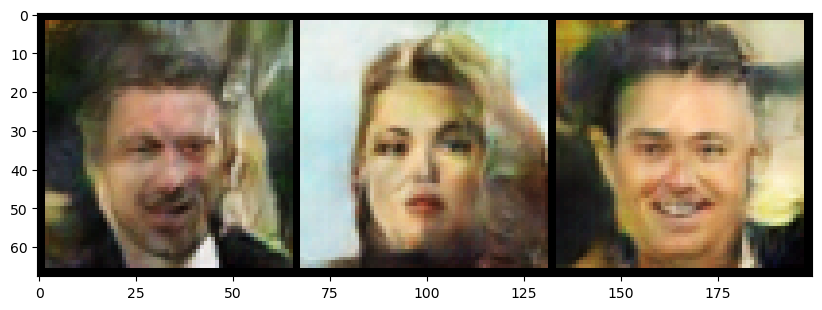

In [15]:
input_shape = (3, nz, 1, 1)
noise = torch.randn(input_shape)
with torch.no_grad():
    out = generator(noise).detach().cpu()
grid = vutils.make_grid(out, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.savefig("8b_generation")

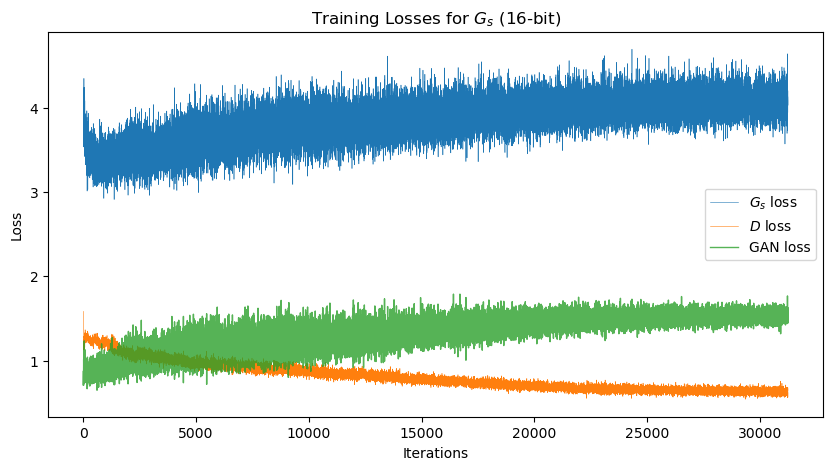

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training Losses for $G_s$ (16-bit)")
plt.plot(ckpt["g_losses"], label="$G_s$ loss", linewidth=.4, alpha=1)
plt.plot(ckpt["d_losses"], label="$D$ loss", linewidth=.4, alpha=1)
#plt.plot(ckpt["g_losses_perceptual"], label="Perceptual loss", linewidth=1.0, alpha=0.8)
plt.plot(ckpt["g_losses_GAN"], label="GAN loss", linewidth=1.0, alpha=0.8)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("16b_loss")
plt.show()

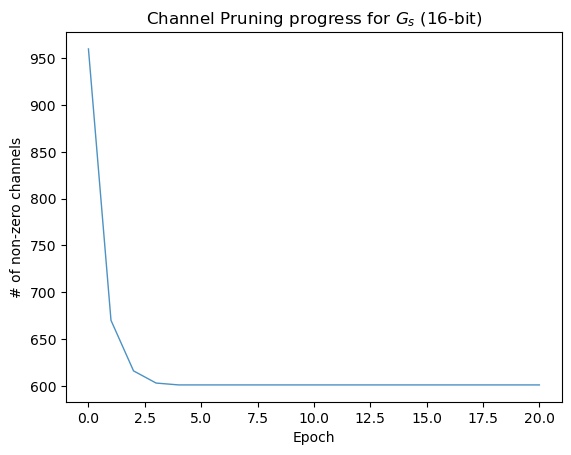

In [20]:
plt.plot(ckpt["channel_number"], label="Channel Number", linewidth=1.0, alpha=0.8)
plt.xlabel("Epoch")
plt.ylabel("# of non-zero channels")
plt.title("Channel Pruning progress for $G_s$ (16-bit)")
plt.savefig("pruning16b")

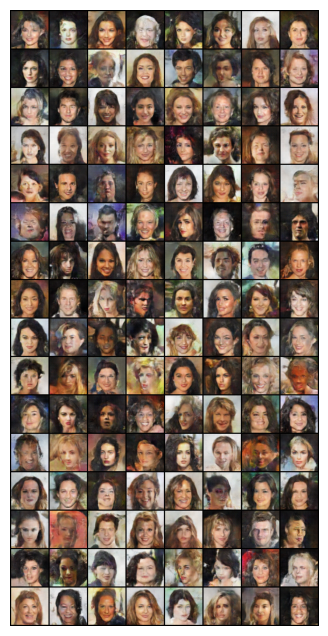

In [11]:
import matplotlib.animation as animation
import numpy as np

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in ckpt["img_progress"]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
FFwriter = animation.FFMpegWriter(fps=5)
ani.save('10e.mp4', writer=FFwriter)

[!] Running quantised model.


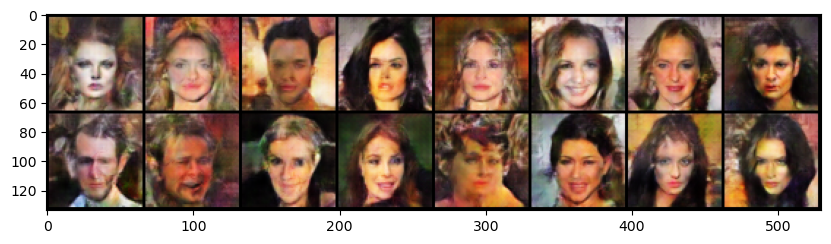

In [19]:
comp_ckpt = torch.load("../out/compressed16b.pth")
compressed = Generator(nz=100, ngf=64, nc=3, quant=True, dims=comp_ckpt["channels"])
compressed.load_state_dict(comp_ckpt["weights"])
input_shape = (16, nz, 1, 1)
noise = torch.randn(input_shape)
with torch.no_grad():
    out = compressed(noise).detach().cpu()
grid = vutils.make_grid(out, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.savefig("dp_generations")

In [9]:
from utils import measure_model
 
generator_ops = measure_model(compressed, (64, nz, 1, 1))
print(f'Compressed Operations: {generator_ops / 1024. / 1024.:.6f}M')

Compressed Operations: 250.046875M
